In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# The tools we need for modeling and metrics
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score

# The special tools for fixing imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import sys

import os
# Configuration
sys.path.append(os.path.abspath('..'))
from src.config import PROCESSED_DATA_DIR

# Set chart style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [4]:
# We use the training data you created in the previous step
X_train = pd.read_csv(PROCESSED_DATA_DIR / 'X_train.csv')
y_train = pd.read_csv(PROCESSED_DATA_DIR / 'y_train.csv').values.ravel()

print(f"Data Loaded. Shape: {X_train.shape}")
print(f"Churn Rate: {y_train.mean():.1%}")

Data Loaded. Shape: (5616, 30)
Churn Rate: 26.4%


In [5]:
# We are testing 3 specific ways to fix the problem
strategies = {
    # 1. Do nothing (Baseline)
    'Baseline': ImbPipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    
    # 2. Tell the model "Churn is important" (Class Weighting)
    'Class Weighting': ImbPipeline([
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    
    # 3. Create fake churners to balance the data (SMOTE)
    'SMOTE': ImbPipeline([
        ('sampler', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

In [6]:
results = []
scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1'}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running comparison...")
for name, pipeline in strategies.items():
    print(f"Testing {name}...")
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    
    results.append({
        'Strategy': name,
        'Recall': np.mean(scores['test_recall']),       # How many churners we caught
        'Precision': np.mean(scores['test_precision']), # How accurate our flags were
        'F1': np.mean(scores['test_f1'])               # The balance between them
    })

# Show the table
pd.DataFrame(results).sort_values(by='Recall', ascending=False)

Running comparison...
Testing Baseline...
Testing Class Weighting...
Testing SMOTE...


,Strategy,Recall,Precision,F1
2,SMOTE,0.588552,0.592129,0.590324
0,Baseline,0.495623,0.646954,0.561143
1,Class Weighting,0.475421,0.647792,0.548227


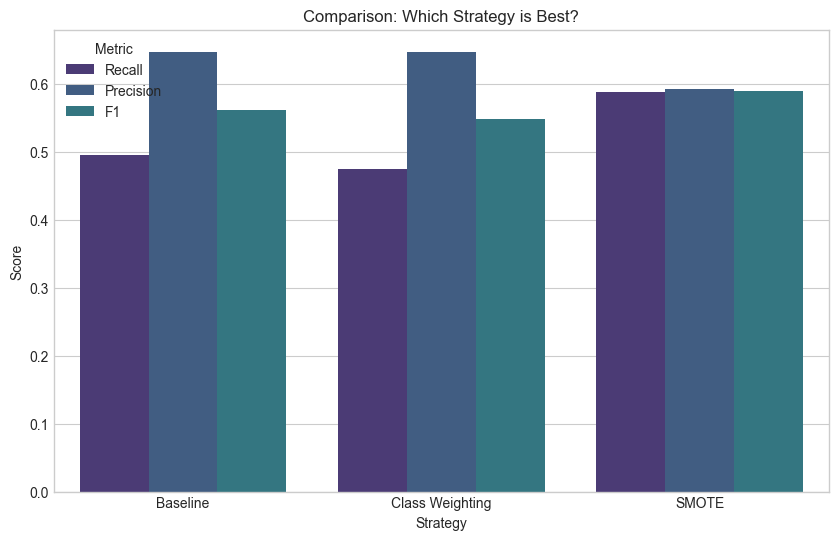

In [7]:
# Make a chart for your report
results_df = pd.DataFrame(results)
results_melted = results_df.melt(id_vars='Strategy', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Strategy', y='Score', hue='Metric', data=results_melted)
plt.title('Comparison: Which Strategy is Best?')
plt.show()